<a href="https://colab.research.google.com/github/dk-wei/tensorflow-dojo/blob/main/tf_keras_regression_customization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

本篇主要讲解customization部分，详见目录。

附：手动求导`tf.GradientTape`部分请参见[Tensorflow_2_0+_Tutorial_手动求导](https://github.com/dk-wei/tensorflow-dojo/blob/main/Tensorflow_2_0%2B_Tutorial_%E6%89%8B%E5%8A%A8%E6%B1%82%E5%AF%BC.ipynb)

In [ ]:
# !pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
# !python -m pip install -U pip
# !pip -V
# !pip install sklearn pandas

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [ ]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [ ]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

#### 自定义DenseLayer样例

In [ ]:
layer = tf.keras.layers.Dense(100, input_shape=(None, 5))   # 一般在第一层接输入的layer，需要指定input shape
layer = tf.keras.layers.Dense(100)
#layer(tf.zeros([10, 5]))

In [ ]:
layer.variables
# x * w + b
#layer.trainable_variables

[]

#### 自定义损失函数

In [ ]:
# 自定义损失函数
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

#### 自定义DenseLayer (Lambda方式)

In [ ]:
# tf.nn.softplus: log(1+e^x)
customized_softplus = keras.layers.Lambda(lambda x : tf.nn.softplus(x))
print(customized_softplus([-10., -5., 0., 5., 10.]))

tf.Tensor([4.5398901e-05 6.7153485e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


#### 自定义DenseLayer (子类方式)

In [ ]:
# customized dense layer.
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        '''构建所需要的参数'''
        # x * w + b. input_shape:[None, a] w:[a, b] output_shape: [None, b]
        self.kernel = self.add_weight(name = 'kernel', 
                                      shape=(input_shape[1], self.units),
                                     initializer = 'uniform',   # 初始化weights
                                     trainable = True)
        
        self.bias = self.add_weight(name = 'bias',
                                   shape = (self.units, ),
                                   initializer = 'zeros',      # 初始化bias
                                   trainable = True)
        super().build(input_shape)
    
    def call(self, x):
        '''完成正向计算'''
        return self.activation(x @ self.kernel + self.bias)

In [ ]:
model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu',
                      input_shape=x_train.shape[1:]),
    CustomizedDenseLayer(1),   # 加入customized layer
    customized_softplus,   # 加入softplus layer

    # softplus层也可以用下列写法
    # keras.layers.Dense(1, activation='softplus')
    # keras.layers.Dense(1), keras.layers.Activation('softplus')
])
model.summary()
model.compile(loss=customized_mse, optimizer='sgd',
             metrics=['mean_squared_error']  # 以mean squared error为metrics，和自定义损失函数比较
              )

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer (Cust (None, 30)                270       
_________________________________________________________________
customized_dense_layer_1 (Cu (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train_scaled, y_train,
                   validation_data=(x_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.1991 - mean_squared_error: 1.1991 - val_loss: 0.6792 - val_mean_squared_error: 0.6792
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5904 - mean_squared_error: 0.5904 - val_loss: 0.5839 - val_mean_squared_error: 0.5839
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5159 - mean_squared_error: 0.5159 - val_loss: 0.5171 - val_mean_squared_error: 0.5171
Epoch 4/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4736 - mean_squared_error: 0.4736 - val_loss: 0.4863 - val_mean_squared_error: 0.4863
Epoch 5/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4552 - mean_squared_error: 0.4552 - val_loss: 0.4673 - val_mean_squared_error: 0.4673
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4544 - mean_squared_error: 0.4544 - val_loss: 0.4934 - val_mean_squared_error: 0.4934
Epoch 7/100
363/363 [=

#### 查看每层Layer的weights, bias

In [ ]:
#model.get_layer(<<layer_name>>).get_weights()[0]

# 方法1
print(model.get_layer('customized_dense_layer').get_weights()[0].shape)
print(model.get_layer('customized_dense_layer').get_weights()[1].shape)

# 方法2
print(model.layers[0].get_weights()[0].shape)
print(model.layers[0].get_weights()[1].shape)

(8, 30)
(30,)
(8, 30)
(30,)


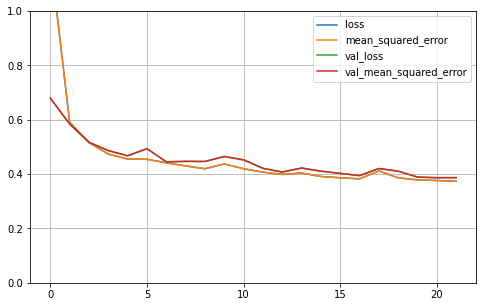

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 900us/step - loss: 0.3891 - mean_squared_error: 0.3891


[0.38913074135780334, 0.38913074135780334]